<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision.transforms as transforms
%matplotlib inline

In [ ]:
import os
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import skimage.io
import pandas as pd

import cv2

from tqdm.notebook import tqdm
from IPython.display import clear_output

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        #print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        #print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        #print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        #print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        #print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
data, attrs = fetch_dataset()

In [ ]:
class LFWDataset(Dataset):
    def __init__(self, data_list, transform):
        self.data = data_list
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        #image = cv2.imread(self.data[index])
        #image = cv2.resize(self.data[index], (64, 64))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(self.data[index])
        return image

In [ ]:
def transform():
    transform = transforms.Compose([
            transforms.ToTensor(),
            #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
    return transform

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.9, shuffle=False)

In [ ]:
trainset = LFWDataset(train_photos, transform=transform())
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
validset = LFWDataset(val_photos, transform=transform())
val_loader = DataLoader(validset, batch_size=32)


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class LinearAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            nn.Linear(64 * 64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 36)
        )
        
        self.dropout = nn.Dropout(0.2)
        self.decoder = torch.nn.Sequential(
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64 * 64),
            nn.Sigmoid()
        )
  
    def forward(self, x):
        x = x.reshape(-1, 64*64)
        latent_code = self.encoder(x)
        reconstruction = self.dropout(self.decoder(latent_code))
        reconstruction = reconstruction.view(-1, 3, 64, 64)
        return reconstruction, latent_code
    
    def sampler(self, z):
        generated = self.decoder(z)
        generated = generated.view(-1, 3, 64, 64)
        return generated

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

**linear autoencoder**

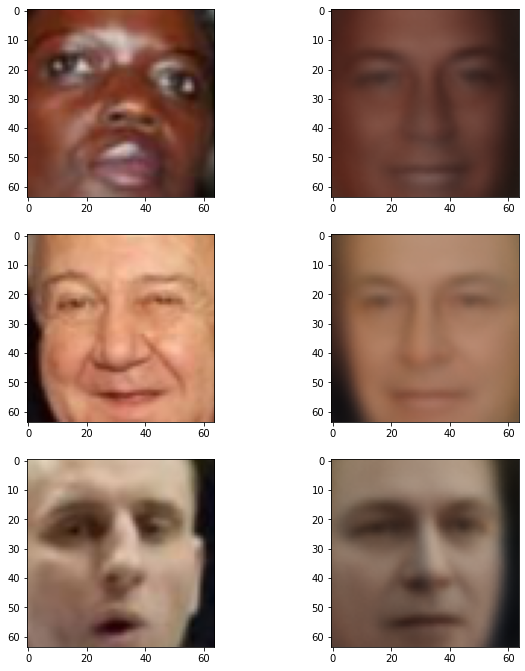

epoch: 49, 
train loss: 0.06559843078658388 
loss: 0.020230678664076896


<All keys matched successfully>

In [ ]:
model = LinearAE().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

n_epochs = 50
train_losses = []
val_losses = []
valid_loss_min = np.Inf

for epoch in tqdm(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        X_batch = X_batch.float()
        reconstructed, latent_code = model(X_batch.to(device))
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
        
    train_losses.append(np.mean(train_losses_per_epoch))
    
    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
            X_batch = X_batch.float()
            reconstructed, latent_code = model(X_batch.to(device))
            
            loss = loss_fn(reconstructed, X_batch.to(device))
            val_losses_per_epoch.append(loss.item())
            
    if val_losses_per_epoch[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        val_losses_per_epoch[-1]))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = val_losses_per_epoch[-1]

    reconstructed = reconstructed.cpu()
    X_batch = X_batch.cpu()
    clear_output(wait=True)
    plt.figure(figsize=(10, 20))
    for i, (gt, res) in enumerate(zip(X_batch[:5], reconstructed[:5])):
        gt = gt.permute(1,2,0).detach().numpy()
        res = res.permute(1,2,0).detach().numpy()
        plt.subplot(5, 2, 2*i+1)
        plt.imshow(gt)
        plt.subplot(5, 2, 2*i+2)
        plt.imshow(res)
    plt.show()

    val_losses.append(np.mean(val_losses_per_epoch))
    print(f'epoch: {epoch}, \ntrain loss: {train_losses[-1]} \nloss: {val_losses[-1]}')
    
# загружаем модель с лучшими весами
model.load_state_dict(torch.load('model.pt'))

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

**Подсказка:** если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

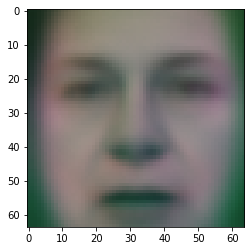

In [ ]:
rand_img = np.random.normal(0, 1, size=(3, 36))
output = model.sampler(torch.FloatTensor(rand_img).to(device))
plt.imshow(output[0].permute(1,2,0).cpu().detach().numpy())

In [ ]:
model.eval()
latent_space = []
for i in iter(trainset):
    reconstructed, latent_code = model(X_batch.to(device))
    latent_space.append(latent_code)

final = None
for i in latent_space:
    if final is None:
        final = i
    else:
        final += torch.tensor(i)

final_mean_tensor = final/len(latent_space)
final_mean_tensor = final_mean_tensor.cpu()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


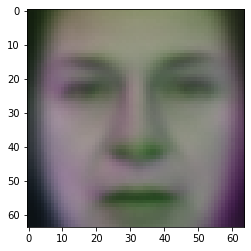

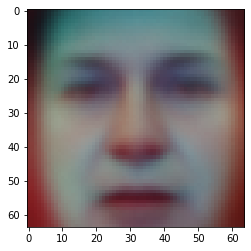

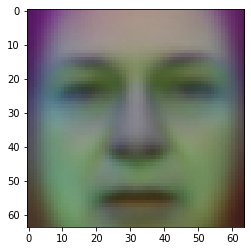

In [ ]:
randoms = []
for m,s in zip(final_mean_tensor.mean(1), final_mean_tensor.std(1)):
    randoms.append(np.random.normal(m.item(), s.item(), size=(36)))
    
rand_img = torch.FloatTensor(randoms)
output = model.sampler(torch.FloatTensor(rand_img).to(device))
plt.imshow(output[0].permute(1,2,0).cpu().detach().numpy())
plt.show()
plt.imshow(output[1].permute(1,2,0).cpu().detach().numpy())
plt.show()
plt.imshow(output[2].permute(1,2,0).cpu().detach().numpy())
plt.show()

## Time to make fun! (4 балла)

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Находим индексы улыбающихся и неулыбающихся людей

In [ ]:
smiling_indexis = train_attrs[train_attrs['Smiling'] > 1.5][['Smiling']].index
not_smiling_indexis = train_attrs[train_attrs['Smiling'] < -1.5][['Smiling']].index

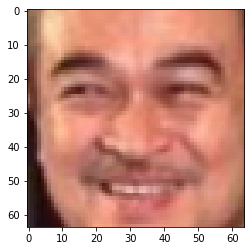

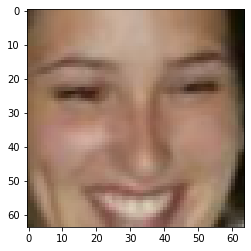

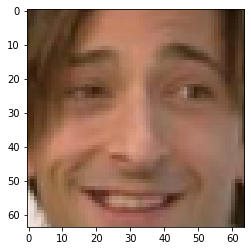

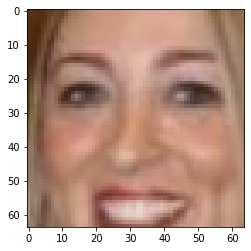

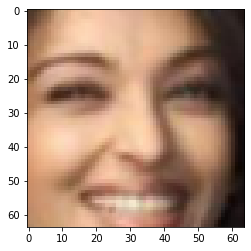

In [ ]:
for i in smiling_indexis[:5]:
    plt.imshow(train_photos[i])
    plt.show()

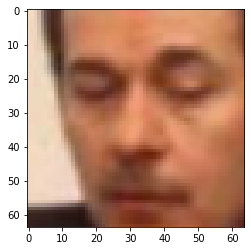

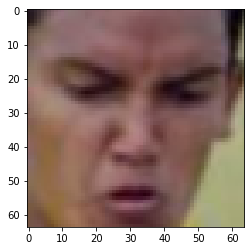

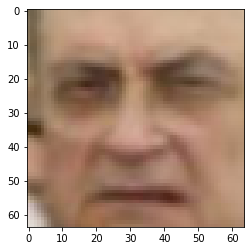

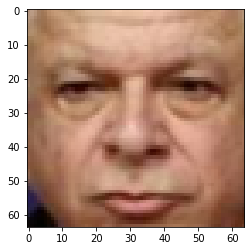

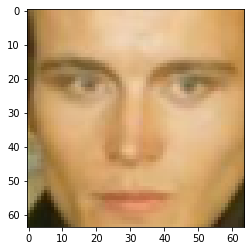

In [ ]:
for i in not_smiling_indexis[:5]:
    plt.imshow(train_photos[i])
    plt.show()

In [ ]:
model.eval()
latent_smile_space = []
with torch.no_grad():
    for idx in smiling_indexis:
        image = torch.FloatTensor(train_photos[idx]).permute(2, 0, 1)
        reconstructed, latent_code = model(image.to(device))
        latent_smile_space.append(latent_code)
        
final = None
for i in latent_smile_space:
    if final is None:
        final = i
    else:
        final += torch.tensor(i)

smile_vector = final/len(latent_smile_space)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
model.eval()
latent_not_smile_space = []
with torch.no_grad():
    for idx in not_smiling_indexis:
        image = torch.FloatTensor(train_photos[idx]).permute(2, 0, 1)
        reconstructed, latent_code = model(image.to(device))
        latent_not_smile_space.append(latent_code)

final = None
for i in latent_smile_space:
    if final is None:
        final = i
    else:
        final += torch.tensor(i)

not_smile_vector = final/len(latent_not_smile_space)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


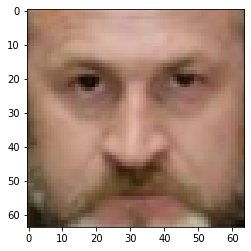

In [ ]:
not_smiling_face = torch.FloatTensor(train_photos[not_smiling_indexis[15]]).permute(2, 0, 1)
plt.imshow(train_photos[not_smiling_indexis[15]])

In [ ]:
reconstructed, latent_code = model(torch.FloatTensor(not_smiling_face).to(device))

In [ ]:
latent_code = latent_code + (smile_vector.to(device)*0.2)

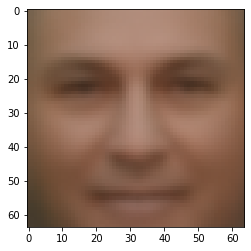

In [ ]:
output = model.sampler(latent_code)
plt.imshow(output[0].permute(1,2,0).cpu().detach().numpy())

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc21 = nn.Linear(512, 20)
        self.fc22 = nn.Linear(512, 20)
        self.relu = nn.ReLU()
        
        self.fc3 = nn.Linear(20, 512)
        self.fc4 = nn.Linear(512, 784)

    def encode(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        mu = self.fc21(x)
        logvar = self.fc22(x)
        return mu, logvar
    
    def decode(self, z):
        z = self.relu(self.fc3(z))
        z = torch.sigmoid(self.fc4(z))
        return z
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z)
        return x, mu, logvar

    def sampler(self, z):
        z = self.decode(z)
        return z

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

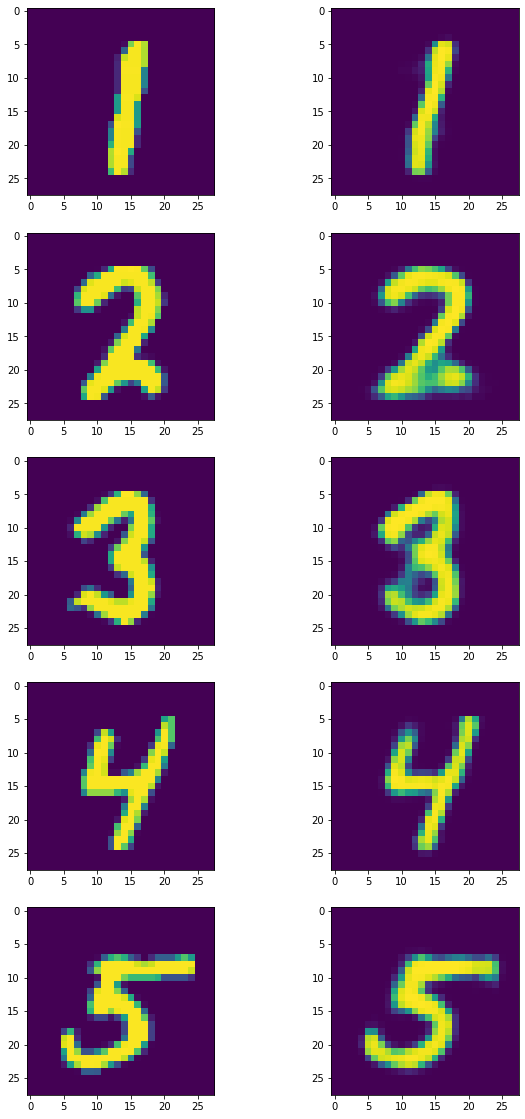

epoch: 50, 
train loss: 3244.853266796875 
loss: 3258.709484746281


<All keys matched successfully>

In [ ]:
criterion = loss_vae
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters())

n_epochs = 50
train_losses = []
val_losses = []
valid_loss_min = np.Inf

for epoch in tqdm(range(n_epochs+1)):
    model.train()
    train_losses_per_epoch = []
    for X_batch, _ in train_loader:
        optimizer.zero_grad()
        X_batch = X_batch.float().to(device)
        out, mu, logVar = model(X_batch)
        out = out.view(-1, 1, 28, 28)
        loss = criterion(X_batch, mu, logVar, out)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
        
    train_losses.append(np.mean(train_losses_per_epoch))
    
    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.float().to(device)
            out, mu, logVar = model(X_batch)
            out = out.view(-1, 1, 28, 28)
            loss = criterion(X_batch, mu, logVar, out)
            val_losses_per_epoch.append(loss.item())
            
    if val_losses_per_epoch[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        val_losses_per_epoch[-1]))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = val_losses_per_epoch[-1]
        
    out = out.cpu()
    X_batch = X_batch.cpu()
    clear_output(wait=True)
    plt.figure(figsize=(10, 20))
    for i, (gt, res) in enumerate(zip(X_batch[:5], out[:5])):
        gt = gt.permute(1,2,0).detach().numpy()
        res = res.permute(1,2,0).detach().numpy()
        plt.subplot(5, 2, 2*i+1)
        plt.imshow(gt)
        plt.subplot(5, 2, 2*i+2)
        plt.imshow(res)
    plt.show()

    val_losses.append(np.mean(val_losses_per_epoch))
    print(f'epoch: {epoch}, \ntrain loss: {train_losses[-1]} \nloss: {val_losses[-1]}')

# загружаем модель с лучшими весами
model.load_state_dict(torch.load('model.pt'))

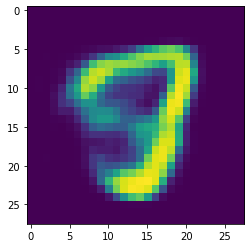

In [ ]:
rand_img = np.random.normal(0, 1, size=(1, 20))
output = model.sampler(torch.FloatTensor(rand_img).to(device))
output = output.view(28, 28, 1).cpu().detach().numpy()
plt.imshow(output)

In [ ]:
model.eval()
latent_space = []
for i, _ in train_loader:
    out, mu, logVar = model(X_batch.to(device))
    latent_space.append(mu)

final = None
for i in latent_space:
    if final is None:
        final = i
    else:
        final += torch.tensor(i)

final_mean_tensor = final/len(latent_space)
final_mean_tensor = final_mean_tensor.cpu()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

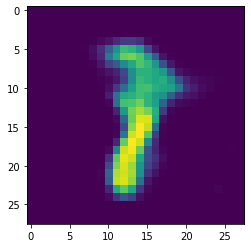

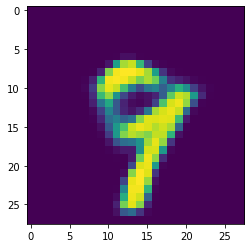

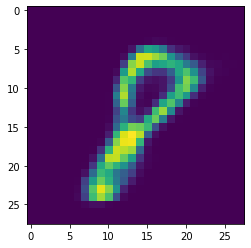

In [ ]:
randoms = []
for m,s in zip(final_mean_tensor.mean(1), final_mean_tensor.std(1)):
    randoms.append(np.random.normal(m.item(), s.item(), size=(20)))
    
rand_img = torch.FloatTensor(randoms)
output = model.sampler(torch.FloatTensor(rand_img).to(device))
plt.imshow(output[0].view(28, 28, 1).cpu().detach().numpy())
plt.show()
plt.imshow(output[1].view(28, 28, 1).cpu().detach().numpy())
plt.show()
plt.imshow(output[2].view(28, 28, 1).cpu().detach().numpy())
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
model.eval()
latent_digits = []
labels = []
with torch.no_grad():
    for x, y in iter(test_dataset):
        out, mu, logVar = model(x.to(device))
        latent_digits.append(mu.cpu().view(20).numpy())
        labels.append(y)
latent_digits = np.asarray(latent_digits)

In [ ]:
tsne = TSNE(n_iter=300)
tsne_results = tsne.fit_transform(latent_digits)

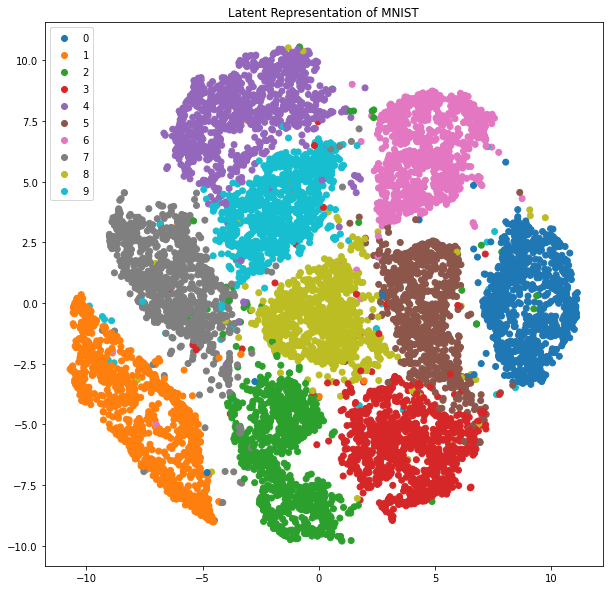

In [ ]:
fig = plt.figure( figsize=(10,10) )
ax = fig.add_subplot(1, 1, 1, title='Latent Representation of MNIST' )
scatter = ax.scatter(
    x=tsne_results[:,0], 
    y=tsne_results[:,1], 
    c=labels, 
    cmap=plt.cm.get_cmap('tab10'))
ax.legend(*scatter.legend_elements(), loc='upper left')
plt.show()

Что вы думаете о виде латентного представления?

Все цифры распределились по своим облакам в векторном пространстве. Некоторые выпадают из своих пузырей. Это видимо те, которые по своему написанию похожи на другие цифры. 

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self, hidden_size=20):
        super(CVAE, self).__init__()
        input_size_with_label = 784 + 10
        hidden_size += 10
        hidden_size_with_labels = hidden_size + 10
        
        self.fc1 = nn.Linear(input_size_with_label,512)
        self.fc21 = nn.Linear(512, hidden_size)
        self.fc22 = nn.Linear(512, hidden_size)
        self.fc3 = nn.Linear(hidden_size_with_labels, 512)
        self.fc4 = nn.Linear(512, 784)

        self.relu = nn.ReLU()
    
    def encode(self, x, labels):
        x = x.view(-1, 1*28*28)
        x = torch.cat((x, labels), 1)
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)
        
    def decode(self, z, labels):
        z = torch.cat((z, labels), 1)
        z = self.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(z))
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def forward(self,x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z, labels)
        return x, mu, logvar
    
    def sampler(self, z, labels):
        z = self.decode(z, labels)
        return z

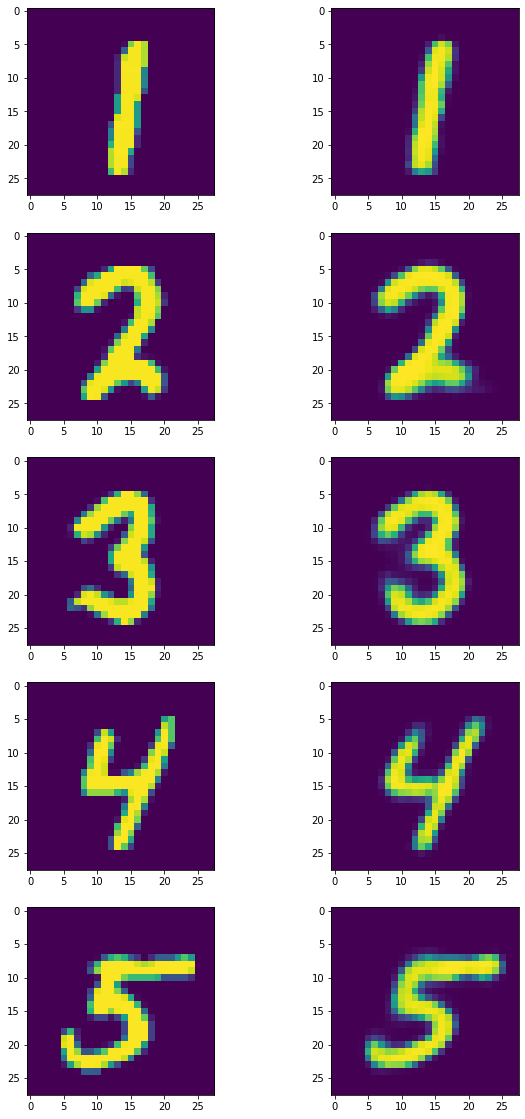

epoch: 50, 
train loss: 3086.7371924479166 
loss: 3100.06639064996


In [ ]:
criterion = loss_vae
model = CVAE().to(device)
optimizer = torch.optim.Adam(model.parameters())
valid_loss_min = np.Inf

n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs+1)):
    model.train()
    train_losses_per_epoch = []
    for X_batch, labels in train_loader:
        optimizer.zero_grad()
        X_batch = X_batch.float().to(device)
        labels = F.one_hot(torch.tensor(labels), 10).to(device) # кодируем лейблы в нули и единицы
        out, mu, logVar = model(X_batch, labels)
        out = out.view(-1, 1, 28, 28)
        loss = criterion(X_batch, mu, logVar, out)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
        
    train_losses.append(np.mean(train_losses_per_epoch))
    
    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch, labels in test_loader:
            X_batch = X_batch.float().to(device)
            labels = F.one_hot(torch.tensor(labels), 10).to(device) # кодируем лейблы в нули и единицы
            out, mu, logVar = model(X_batch, labels)
            out = out.view(-1, 1, 28, 28)
            loss = criterion(X_batch, mu, logVar, out)
            val_losses_per_epoch.append(loss.item())
            
    if val_losses_per_epoch[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        val_losses_per_epoch[-1]))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = val_losses_per_epoch[-1]

    out = out.cpu()
    X_batch = X_batch.cpu()
    clear_output(wait=True)
    plt.figure(figsize=(10, 20))
    for i, (gt, res) in enumerate(zip(X_batch[:5], out[:5])):
        gt = gt.permute(1,2,0).detach().numpy()
        res = res.permute(1,2,0).detach().numpy()
        plt.subplot(5, 2, 2*i+1)
        plt.imshow(gt)
        plt.subplot(5, 2, 2*i+2)
        plt.imshow(res)
    plt.show()

    val_losses.append(np.mean(val_losses_per_epoch))
    print(f'epoch: {epoch}, \ntrain loss: {train_losses[-1]} \nloss: {val_losses[-1]}')

In [ ]:
# загружаем модель с лучшими весами
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

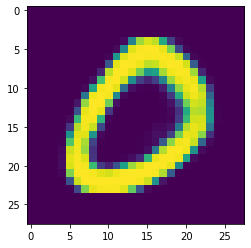

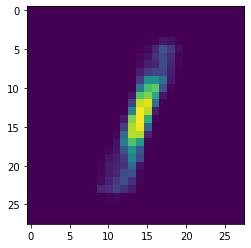

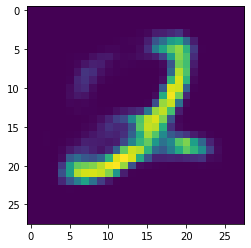

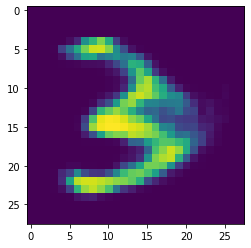

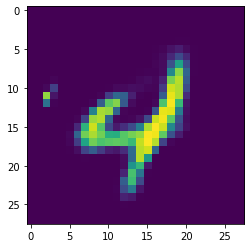

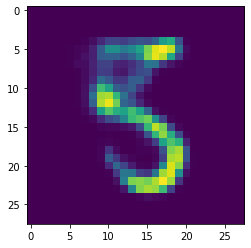

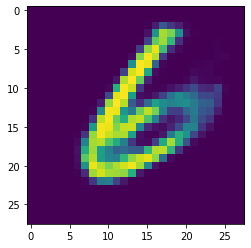

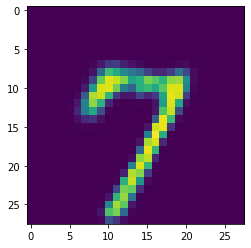

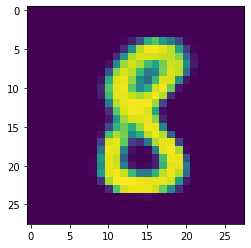

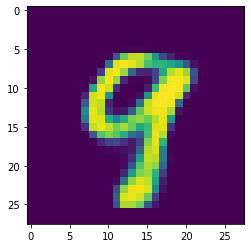

In [ ]:
model = model.cpu()
model.eval()
for i in range(10):
    out = model.sampler(torch.FloatTensor(np.random.normal(0, 1, size=(1, 30))),  F.one_hot(torch.tensor(i), 10).view(1, -1))
    plt.imshow(out.view(28,28,1).detach().numpy())
    plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
model = model.to(device)
model.eval()
latent_digits = []
labels = []
with torch.no_grad():
    for x, y in iter(test_dataset):
        label = F.one_hot(torch.tensor(y), 10).view(1, -1).to(device)
        out, mu, logVar = model(x.to(device), label)
        latent_digits.append(mu.cpu().view(30).numpy())
        labels.append(y)
latent_digits = np.asarray(latent_digits)

In [ ]:
tsne = TSNE(n_iter=300)
tsne_results = tsne.fit_transform(latent_digits)

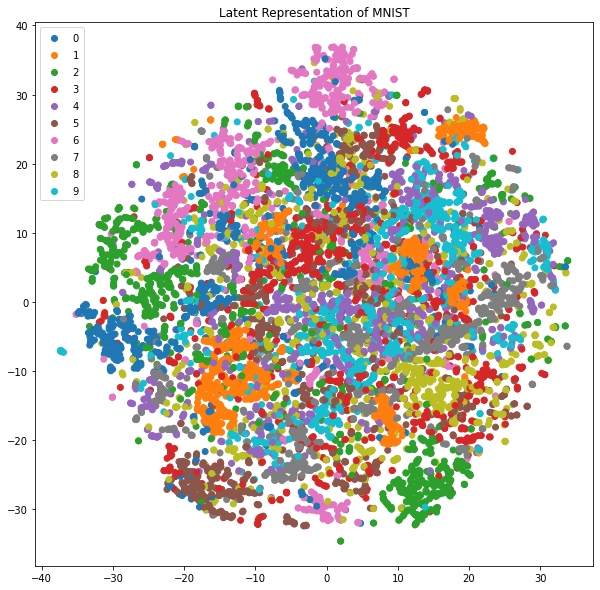

In [ ]:
fig = plt.figure( figsize=(10,10) )
ax = fig.add_subplot(1, 1, 1, title='Latent Representation of MNIST' )
scatter = ax.scatter(
    x=tsne_results[:,0], 
    y=tsne_results[:,1], 
    c=labels, 
    cmap=plt.cm.get_cmap('tab10'))
ax.legend(*scatter.legend_elements(), loc='upper left')
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Вместо структурированных облаков получился один плотный пузырь, где все классы перемешанны. Можно, конечно, разглядеть отдельные кластеры, но они сильно смешаны с другими классами цифр. 

Также интересно то, что один и тот же класс цифр образует сразу несколько кластеров в разных частях векторного пространста. Это особенно хорошо видно на двойках и нулях. 